In [95]:
'''
Machine learning for the 2D planestress problem using ensemble models
Last Updated : 04/04/2019, by Hyungmin Jun (hyungminjun@outlook.com)

=============================================================================

Copyright 2019 Hyungmin Jun. All rights reserved.

License - GPL version 3
This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or any later version. This
program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
'''

'\nMachine learning for the 2D planestress problem using ensemble models\nLast Updated : 04/04/2019, by Hyungmin Jun (hyungminjun@outlook.com)\n\n=============================================================================\n\nCopyright 2019 Hyungmin Jun. All rights reserved.\n\nLicense - GPL version 3\nThis program is free software: you can redistribute it and/or modify it under\nthe terms of the GNU General Public License as published by the Free Software\nFoundation, either version 3 of the License, or any later version. This\nprogram is distributed in the hope that it will be useful, but WITHOUT ANY\nWARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR\nA PARTICULAR PURPOSE. See the GNU General Public License for more details.\nYou should have received a copy of the GNU General Public License along with\nthis program. If not, see <http://www.gnu.org/licenses/>.\n'

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import time

from keras.models import Model
from keras.layers import Input, Dense, concatenate

from sklearn.preprocessing import *
from numpy.linalg import inv

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [97]:
allfiles = glob.glob('../data/stress_planestress\\*.csv')

num_datapoints = 1071

in_data  = np.zeros([len(allfiles) * num_datapoints, 3])
out_data = np.zeros(len(allfiles) * num_datapoints)

for i, datafile in enumerate(allfiles):
    
    force = int(datafile.split('\\')[1].split('-')[0]) / float(50000)
    
    # Set force data
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 0] = np.array([force] * num_datapoints)
    
    data = np.loadtxt(fname = datafile, delimiter = ' ')
    
    # Set x position
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 1] = data[:, 0]
    
    # Set y posistion
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 2] = data[:, 1]
    
    # Set the stress
    out_data[i * num_datapoints:(i + 1) * num_datapoints] = data[:, 3] / float(50000)

# Split arrays or matrices into random train and test subsets
# Parameters:
# test_size : float, int or None, optional (default=0.25)
# random_state : int, RandomState instance or None, optional (default=None)
# shuffle : boolean, optional (default=True)
x_train, x_test, y_train, y_test = train_test_split(in_data, out_data, test_size=0.2, random_state=1, shuffle=True)

# xy_train; x and y position vectors
x1_train = x_train[:, 1:]

# xy_test; x and y position vectors
x1_test = x_test[:, 1:]

# force_train; 
x2_train = x_train[:, 0]

# force_test; 
x2_test = x_test[:, 0]

print('x1_train = ', x1_train.shape)
print('x2_train = ', x2_train.shape)
print('y_train  = ', y_train.shape)
print('')
print('x1_test  = ', x1_test.shape)
print('x2_test  = ', x2_test.shape)
print('y_test   = ', y_test.shape)

x1_train =  (86536, 2)
x2_train =  (86536,)
y_train  =  (86536,)

x1_test  =  (21635, 2)
x2_test  =  (21635,)
y_test   =  (21635,)


In [98]:
def abs_pred(y_true, y_pred):
    return abs((y_true - y_pred) / y_true) < 0.1

In [99]:
import keras.backend as K
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [100]:
numnodes = 20

# Input layer #1, x and y coordinate
input1 = Input(shape=(2, ))

# Input layer #2, force
input2 = Input(shape=(1, ))

# Model 1
x1 = Dense(numnodes, activation='tanh')(input1)
#x1 = Dense(2, activation='tanh')(x1)
#x1 = Dense(2, activation='tanh')(x1)

# model 2 
x2 = Dense(numnodes, activation='relu')(input2)
#x2 = Dense(2, activation='relu')(x2)
#x2 = Dense(2, activation='relu')(x2)

# Merge models
x3   = concatenate(inputs=[x1, x2])
x3   = Dense(numnodes, activation='tanh')(x3)
x3   = Dense(numnodes, activation='tanh')(x3)
pred = Dense(1,        activation='linear')(x3)

# Creates a model that includes the Input layers and three Dense layers
model = Model(inputs=[input1, input2], outputs=pred)

# Compile the model
#model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['accuracy', abs_pred])
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy', abs_pred])
model.summary()

# Train the model
#hist = model.fit([x1_train, x2_train], y_train, epochs=50, batch_size=100, verbose=2)
hist = model.fit([x1_train, x2_train], y_train, validation_data=([x1_test, x2_test], y_test), epochs=50, batch_size=100, verbose=2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 20)           60          input_15[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 20)           40          input_16[0][0]                   
__________________________________________________________________________________________________
concatenat

In [101]:
score = model.evaluate([x1_test, x2_test], y_test)
print(score)

21635/21635 [==============================] - 0s 15us/step
[0.011756852271927678, 0.009660272706263, 0.9247977813727756]


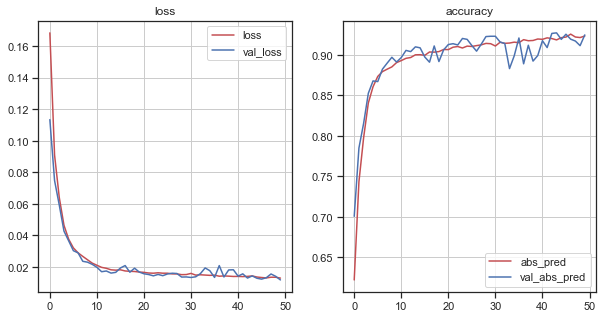

In [102]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'], color='b')
plt.legend(['loss','val_loss'])
plt.title('loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(hist.history['abs_pred'], color='r')
plt.plot(hist.history['val_abs_pred'], color='b')
plt.legend(['abs_pred','val_abs_pred'])
plt.title('accuracy')
plt.grid()

In [103]:
from numpy import genfromtxt
data = genfromtxt('../data/stress_planestress\\0-sigmaSurface.csv', delimiter=' ')

pos_xy = data[:, [0, 1]]
stress = np.zeros(shape=(1071, 1))
stress.fill(1000/50000)

y_pred = model.predict([pos_xy, stress]) * 50000

print(y_pred)

[[ 378.12573  ]
 [ 739.64575  ]
 [1132.4342   ]
 ...
 [  -6.2350183]
 [ -56.63093  ]
 [ -95.762314 ]]
